# Environment

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import anndata as ad
import warnings
from celltypist import models, annotate

In [2]:
os.chdir("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/cell_typist")

In [3]:
sel_model = "Mouse_Dentate_Gyrus"
sel_sample = "Nestin_Mut"

In [4]:
# Specific mouse brain models available in CellTypist
# https://www.celltypist.org/models
MOUSE_HIPPOCAMPUS_MODELS = {
    "Mouse_Isocortex_Hippocampus": {
        "description": "Cell types from the adult mouse isocortex (neocortex) and hippocampal formation",
        "cell_types": 42,
        "version": "v1",
        "reference": "https://doi.org/10.1016/j.cell.2021.04.021"
    },
    "Mouse_Dentate_Gyrus": {
        "description": "Cell types from the dentate gyrus in perinatal, juvenile, and adult mice",
        "cell_types": 24,
        "version": "v1",
        "reference": "https://doi.org/10.1038/s41593-017-0056-2"
    }
}

In [5]:
# Set up directories
results_dir = f"results_{sel_model}"
model_dir = "models"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [6]:
# DATA dirs
base_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_"
adata_paths = {
    "Emx1_Ctrl": f"{base_path}Emx1_Ctrl_adult_0/adata.h5ad",
    "Emx1_Mut": f"{base_path}Emx1_Mut_adult_1/adata.h5ad",
    "Nestin_Ctrl": f"{base_path}Nestin_Ctrl_adult_2/adata.h5ad",
    "Nestin_Mut": f"{base_path}Nestin_Mut_adult_3/adata.h5ad"
}

In [7]:
adata_path = adata_paths[sel_sample]
model_path = f"models/{sel_model}.pkl"

# Load Data

In [8]:
if adata_path:
    print(f"Loading AnnData from {adata_path}")
    adata = sc.read_h5ad(adata_path)
else:
    # Try to use a global adata object
    try:
        adata = globals()['adata']
        print("Using already loaded AnnData object")
    except KeyError:
        print("No AnnData object provided. Please provide a path to an .h5ad file.")

print(f"AnnData object contains {adata.n_obs} cells and {adata.n_vars} genes")

Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_Nestin_Mut_adult_3/adata.h5ad


AnnData object contains 9237 cells and 26095 genes


In [9]:
model = models.Model.load(model_path)

# Explore cell annotation model

In [10]:
print(type(model))
print(model.__dict__.keys())
print(model.description)
print(f"Model: {os.path.basename(model_path)}")
print(f"Number of cell types: {len(model.cell_types)}")

<class 'celltypist.models.Model'>
dict_keys(['classifier', 'scaler', 'description'])
{'date': '2023-07-14 20:03:58.410321', 'details': 'cell types from the dentate gyrus in perinatal, juvenile, and adult mice', 'url': 'https://celltypist.cog.sanger.ac.uk/models/Mouse_DG_Hochgerner/v1/Mouse_Dentate_Gyrus.pkl', 'source': 'https://doi.org/10.1038/s41593-017-0056-2', 'version': 'v1', 'number_celltypes': 24}
Model: Mouse_Dentate_Gyrus.pkl
Number of cell types: 24


In [11]:
# Inspect all available attributes and methods of the model object
print("Available attributes and methods:")
for attr in dir(model):
    if not attr.startswith('__'):  # Skip dunder methods
        attr_type = type(getattr(model, attr))
        print(f"  - {attr}: {attr_type}")

Available attributes and methods:
  - cell_types: <class 'numpy.ndarray'>
  - classifier: <class 'sklearn.linear_model._logistic.LogisticRegression'>
  - convert: <class 'method'>
  - description: <class 'dict'>
  - extract_top_markers: <class 'method'>
  - features: <class 'numpy.ndarray'>
  - load: <class 'function'>
  - predict_labels_and_prob: <class 'method'>
  - scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
  - write: <class 'method'>


In [12]:
# Display original array for reference
model.cell_types

array(['Astro-adult', 'Astro-juv', 'CA3-Pyr', 'Cajal-Retzius',
       'Endothelial', 'Ependymal', 'GABA', 'GC-adult', 'GC-juv',
       'Immature-Astro', 'Immature-GABA', 'Immature-GC', 'Immature-Pyr',
       'MOL', 'MiCajal-Retziusoglia', 'NFOL', 'Neuroblast', 'OPC', 'PVM',
       'RGL', 'RGL_young', 'VLMC', 'nIPC', 'nIPC-perin'], dtype=object)

In [13]:
print("\nCell types:")
for i, cell_type in enumerate(model.cell_types):
    print(f"  {i+1}. {cell_type}")


Cell types:
  1. Astro-adult
  2. Astro-juv
  3. CA3-Pyr
  4. Cajal-Retzius
  5. Endothelial
  6. Ependymal
  7. GABA
  8. GC-adult
  9. GC-juv
  10. Immature-Astro
  11. Immature-GABA
  12. Immature-GC
  13. Immature-Pyr
  14. MOL
  15. MiCajal-Retziusoglia
  16. NFOL
  17. Neuroblast
  18. OPC
  19. PVM
  20. RGL
  21. RGL_young
  22. VLMC
  23. nIPC
  24. nIPC-perin


In [14]:
# Extract some key marker genes
print("\nExtracting markers for key cell types...")
for cell_type in model.cell_types:
    markers = model.extract_top_markers(cell_type, 5)
    print(f"\nTop 5 markers for {cell_type}:")
    for marker in markers:
        print(f"  - {marker}")



Extracting markers for key cell types...

Top 5 markers for Astro-adult:
  - Mt2
  - S1pr1
  - Gja1
  - Mt1
  - Gstm1

Top 5 markers for Astro-juv:
  - Arxes2
  - Hmgcs1
  - Btbd17
  - Gstm5
  - 6330403K07Rik

Top 5 markers for CA3-Pyr:
  - Sv2b
  - Cck
  - Rasgrp1
  - Pde1a
  - Hpca

Top 5 markers for Cajal-Retzius:
  - Lhx5
  - Gm27199
  - Reln
  - Lhx1os
  - Lhx1

Top 5 markers for Endothelial:
  - Slco1a4
  - Ebf1
  - Pcp4l1
  - Rgs5
  - Igfbp7

Top 5 markers for Ependymal:
  - 2410004P03Rik
  - Tekt1
  - Calml4
  - Mlf1
  - Cfap126

Top 5 markers for GABA:
  - Gad2
  - Erbb4
  - Gad1
  - Slc32a1
  - Impact

Top 5 markers for GC-adult:
  - Slc24a5
  - Nptx1
  - Marf1
  - Gas7
  - Pam

Top 5 markers for GC-juv:
  - Ubb
  - Rnf121
  - Camk2a
  - Rplp0
  - Paqr9

Top 5 markers for Immature-Astro:
  - Id3
  - Ednrb
  - Igfbp2
  - Lxn
  - Ncan

Top 5 markers for Immature-GABA:
  - Dlx1
  - Dlx5
  - Dlx2
  - Npas1
  - Rpp25

Top 5 markers for Immature-GC:
  - Cntnap5a
  - Nrgn
  - Pcp4


# Annotate data

In [15]:
non_zero_index = adata.raw.X[0].indices[0] if len(adata.raw.X[0].indices) > 0 else 0
print(adata.raw.X[0,12])
print(adata.X[0,12])

0.0
0.0


In [16]:
adata.layers

Layers with keys: for_cell_typist

In [17]:
adata_norm = adata.copy()

In [18]:
adata_norm.X = adata.layers['for_cell_typist']

In [19]:
# Quick check that normalization worked correctly
counts_after_norm = np.expm1(adata_norm.X).sum(axis=1)
print(np.mean(counts_after_norm))

# Basic QC check
if np.mean(counts_after_norm) < 9000 or np.mean(counts_after_norm) > 11000:
    warnings.warn("Normalization may not have worked as expected. Check your data.")

10000.002


In [20]:
majority_voting = True
prob_threshold = 0.5
print(f"Running CellTypist with majority_voting={majority_voting}, prob_threshold={prob_threshold}")
predictions = annotate(
    adata_norm, 
    model=model_path,
    majority_voting=majority_voting,
    mode='prob match',  # Use probability-based matching for multi-label classification
    p_thres=prob_threshold
)

🔬 Input data has 9237 cells and 26095 genes


🔗 Matching reference genes in the model


Running CellTypist with majority_voting=True, prob_threshold=0.5


🧬 3879 features used for prediction


⚖️ Scaling input data


🖋️ Predicting labels


✅ Prediction done!


👀 Can not detect a neighborhood graph, will construct one before the over-clustering


⛓️ Over-clustering input data with resolution set to 10


🗳️ Majority voting the predictions


✅ Majority voting done!


In [21]:
# Add annotations to original adata
predictions.to_adata(adata_norm)

AnnData object with n_obs × n_vars = 9237 × 26095
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'over_clustering'
    obsm: 'X_pca'
    layers: 'for_cell_typist'
    obsp: 'connectivities', 'distances'

In [22]:
# Also add probability scores for key cell types
predictions.to_adata(adata_norm, insert_prob=True, prefix='prob_')

AnnData object with n_obs × n_vars = 9237 × 26095
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'prob_predicted_labels', 'prob_over_clustering', 'prob_majority_voting', 'prob_conf_score', 'prob_Astro-adult', 'prob_Astro-juv', 'prob_CA3-Pyr', 'prob_Cajal-Retzius', 'prob_Endothelial', 'prob_Ependymal', 'prob_GABA', 'prob_GC-adult', 'prob_GC-juv', 'prob_Immature-Astro', 'prob_Immature-GABA', 'prob_Immature-GC', 'prob_Immature-Pyr', 'prob_MOL', 'prob_MiCajal-Retziusoglia', 'prob_NFOL', 'prob_Neuroblast', 'prob_OPC', 'prob_PVM', 'prob_RGL', 'prob_RGL_young', 'prob_VLMC', 'prob_nIPC', 'prob_nIPC-perin'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'over_clustering'
    obsm: 'X_pca'
    layer

In [23]:
if 'X_umap' not in adata_norm.obsm:
    try:
        # Calculate neighborhood graph if not present
        if 'neighbors' not in adata_norm.uns:
            sc.pp.neighbors(adata_norm)
        sc.tl.umap(adata_norm)
    except Exception as e:
        print(f"Could not calculate UMAP: {e}")
        if 'X_pca' not in adata_norm.obsm:
            sc.pp.pca(adata_norm)

# Inspect results

In [24]:
adata_norm.obs.columns

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'predicted_labels', 'over_clustering',
       'majority_voting', 'conf_score', 'prob_predicted_labels',
       'prob_over_clustering', 'prob_majority_voting', 'prob_conf_score',
       'prob_Astro-adult', 'prob_Astro-juv', 'prob_CA3-Pyr',
       'prob_Cajal-Retzius', 'prob_Endothelial', 'prob_Ependymal', 'prob_GABA',
       'prob_GC-adult', 'prob_GC-juv', 'prob_Immature-Astro',
       'prob_Immature-GABA', 'prob_Immature-GC', 'prob_Immature-Pyr',
       'prob_MOL', 'prob_MiCajal-Retziusoglia', 'prob_NFOL', 'prob_Neuroblast',
       'prob_OPC', 'prob_PVM', 'prob_RGL', 'prob_RGL_young', 'prob_VLMC',
       'prob_nIPC', 'prob_nIPC-perin'],
      dtype='object')

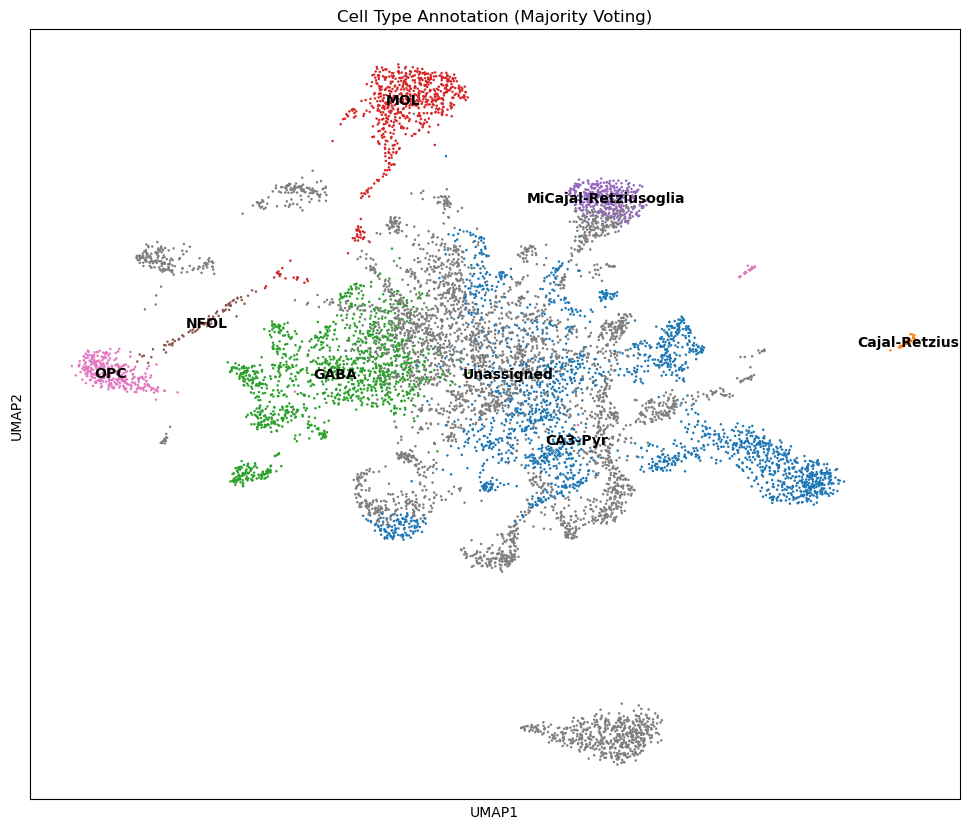

<Figure size 640x480 with 0 Axes>

In [25]:
# Cell type annotation plot
if 'majority_voting' in adata_norm.obs.columns:
    fig, ax = plt.subplots(figsize=(12, 10))
    sc.pl.umap(adata_norm, color='majority_voting', ax=ax, legend_loc='on data', 
                title="Cell Type Annotation (Majority Voting)")
    plt.tight_layout()
    plt.show()

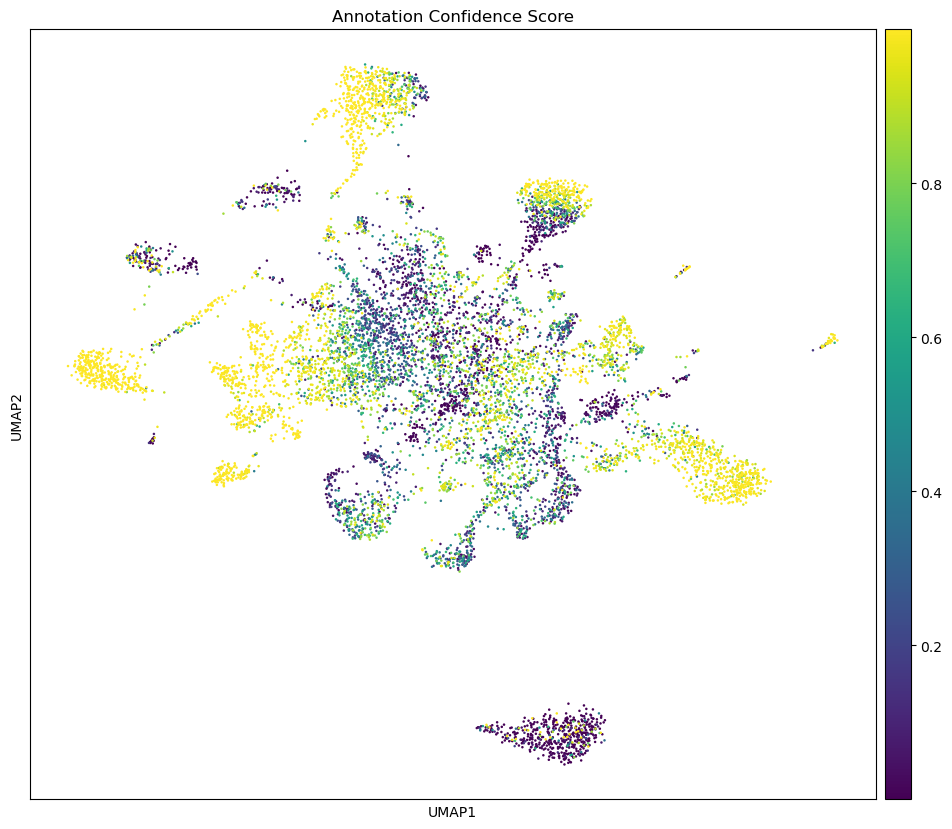

<Figure size 640x480 with 0 Axes>

In [26]:
# Confidence score plot
if 'conf_score' in adata_norm.obs.columns:
    fig, ax = plt.subplots(figsize=(12, 10))
    sc.pl.umap(adata_norm, color='conf_score', ax=ax, 
                title="Annotation Confidence Score", cmap='viridis')
    plt.tight_layout()
    plt.show()